# RDA Remote Access

For users without access to NCAR compute servers and storage, there are still many ways to access data in the Research Data Archive (RDA).   These range from manual download of individual files, to calling remote data services for subsetting data and downloading specific regions of interest, to computer-assisted transfer of many data files.

We will go over these in detail below.

## Use Case:   Wind Farm Productivity Analysis

Suppose someone wants to know the potential amount of electricity that could be generated from a wind farm near Cheyenne, Wyoming.   This means knowing something about the wind speeds in the area, which could vary with the seasons. We might be interested in looking at wind speeds over a single season, or wind speeds over several consecutive years.   In this notebook, we will demonstrate how to do both.

The RDA Thredds Data Server has this dataset with surface wind observational data: [ERA5 Reanalysis (0.25 Degree Latitude-Longitude Grid)](https://rda.ucar.edu/datasets/ds633-0/)

Among the available data products is a global atmospheric surface analysis in either GRIB or NetCDF format.   

Note that we could download the data files directly, but this would be expensive and time-consuming because each data file contains data for the entire globe.  In this example, we care only about one location in Wyoming.  So instead of downloading data for the entire globe, we will use the Xarray and Dask python libraries to load and plot only the data associated with Cheyenne, Wyoming.

We will show how to access this dataset, specify which portion of the dataset we wish to extract, and plot the extracted values.

In [1]:
import xarray as xr
import intake
from siphon.catalog import TDSCatalog

import numpy as np
from matplotlib import pyplot as plt

import os

Here are a few helper functions for wind speed calculation and plotting:

In [2]:
def wind_speed(u, v, units=None):
    """Compute the wind speed from u and v-components.
       If units is 'mph', convert from "meters per second" to "miles per hour".
    """
    speed = np.hypot(u, v)
    if units == 'mph':
        speed = 2.37 * speed
    return speed

In [3]:
def plot_winds(u_values, v_values, time_values):
    """ Compute wind speed values and plot them on a line plot.
    """
    winds = wind_speed(u_values, v_values, units='mph')
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot(time_values, winds, color='r')
    ax.set_title('Hourly Average Wind Speeds for Cheyenne, Wyoming')
    ax.set_ylabel('Miles Per Hour')
    return fig

# THREDDS Data Server

The RDA THREDDS data server provides many options for downloading and subsetting data.  However, it also allows each dataset to be configured differently for different use cases.   This means that a particular download or subset method may work for one dataset, but not for another.   

In the sections below, we try to demonstrate the most general methods for downloading and subsetting in python.   These should work well in a large number of cases.  

## Using the Intake-Thredds Library

The [intake-thredds](https://intake-thredds.readthedocs.io/en/latest/) library is a powerful way of interacting with THREDDS data servers.  It allows a user to specify a high-level data catalog and then merge together some portion of the data files within that catalog.  It can produce a single xarray dataset from many data files, provided those files can be combined along a coordinate dimension such as time.   All other dimensions in the dataset must match in order for the merge to succeed; in other words, when merging across the time dimension, the geospatial grid dimensions must be identical across all merged files. 

One difficulty with using THREDDS is finding the catalog description for a particular dataset.   We start with the reanalysis dataset we are interested in:  [ERA5 Reanalysis (0.25 Degree Latitude-Longitude Grid)](https://rda.ucar.edu/datasets/ds633-0/)

On this page, we click the [Data Access Tab](https://rda.ucar.edu/datasets/ds633.0/dataaccess/) to find a table of THREDDS Access Points.  We then find the "ERA5 atmospheric surface analysis [netCDF4]" row and click on the [TDS Access](https://thredds.rda.ucar.edu/thredds/catalog/files/g/ds633.0/e5.oper.an.sfc/catalog.html) link with the URL:

https://thredds.rda.ucar.edu/thredds/catalog/files/g/ds633.0/e5.oper.an.sfc/catalog.html.   

This URL allows us to see the catalog description in HTML form.   However, intake-thredds wants a description of the same catalog in XML form.   We simply change the "html" ending on this URL to "xml" and this gives us the catalog URL needed by intake-thredds:

In [4]:
catalog_url = 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/ds633.0/e5.oper.an.sfc/catalog.xml'

# This catalog subdirectory pattern will match data for October, November, and December of 2022.
year_month_pattern = '20221*'

# These filename patterns refer to u- and v-components of winds at 10 meters above the land surface.
filename_pattern_u = 'e5.oper.an.sfc.228_131_u10n.ll025sc.*.nc'
filename_pattern_v = 'e5.oper.an.sfc.228_132_v10n.ll025sc.*.nc'

In [5]:
# Collect data for the u-component of winds.

# The "paths" variable specifies which branches of the catalog tree to search for matching data files.
paths = [year_month_pattern, filename_pattern_u]
src = intake.open_thredds_merged(catalog_url, paths)
ds_u = src.to_dask()
ds_u

Dataset(s):   0%|                                        | 0/3 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:    (time: 2208, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2022-10-01 ... 2022-12-31T23:00:00
Data variables:
    U10N       (time, latitude, longitude) float32 dask.array<chunksize=(744, 721, 1440), meta=np.ndarray>
    utc_date   (time) int32 dask.array<chunksize=(744,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB1 da...
    NETCDF_VERSION:                  4.8.1
    CONVERSION_PLATFORM:             Linux r6i5n6 4.12.14-95.51-default #1 SM...
    CONVERSION_DATE:                 Sat Dec 31 21:12:00 MST 2022
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Sat Dec 31 21:12:19 2022: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 5.0.3 (Homepage...
    _NCProperties:                   version=2,netcdf=4.8.1,hdf5=1.10.8
    DODS_EXTRA.Unlimited_Dimension:  time

In [6]:
# Collect data for the v-component of winds 

# The "paths" variable specifies which branches of the catalog tree to search for matching data files.
paths = [year_month_pattern, filename_pattern_v]
src = intake.open_thredds_merged(catalog_url, paths)
ds_v = src.to_dask()
ds_v

Dataset(s):   0%|                                        | 0/3 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:    (time: 2208, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2022-10-01 ... 2022-12-31T23:00:00
Data variables:
    V10N       (time, latitude, longitude) float32 dask.array<chunksize=(744, 721, 1440), meta=np.ndarray>
    utc_date   (time) int32 dask.array<chunksize=(744,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB1 da...
    NETCDF_VERSION:                  4.8.1
    CONVERSION_PLATFORM:             Linux r6i5n6 4.12.14-95.51-default #1 SM...
    CONVERSION_DATE:                 Sat Dec 31 21:15:20 MST 2022
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Sat Dec 31 21:15:39 2022: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 5.0.3 (Homepage...
    _NCProperties:                   version=2,netcdf=4.8.1,hdf5=1.10.8
    DODS_EXTRA.Unlimited_Dimension:  time

The entire dataset contains (2208 x 721 x 1440) = 2.29 billion values, but we are only interested in the 2208 time-indexed values associated with Cheyenne, Wyoming.   By subsetting the data, we reduce the required data I/O by a factor of one million.

By clicking on the disk-shaped icon to the right of V10N above, we can verify that the entire dataset would require at least 8.54 GiB of memory to load.   We will use subsetting to achieve a drastic reduction in time and memory resources.

In [7]:
# Select data for a specific geographic location (Cheyenne, Wyoming).
# Note that dataset longitude values are in the range [0, 360]; click the disk icon to the right of 
#   "longitude" above to verify.
# We convert from longitude values provided by Google in the range [-180, 180] using subtraction.

cheyenne = {'lat': 41.14, 'lon': 360 - 104.82}
boulder =  {'lat': 40.01, 'lon': 360 - 105.27}

city = cheyenne

# Select the nearest grid cell to our lat/lon location.
u = ds_u['U10N'].sel(latitude = city['lat'], longitude= city['lon'], method='nearest')
v = ds_v['V10N'].sel(latitude = city['lat'], longitude= city['lon'], method='nearest')

Up to now, only the dataset structure has been loaded into memory.   The next assignment steps pull the subsetted data values into memory.

In [8]:
%%time 

# Actually load the selected data into memory.
u_values = u.values
v_values = v.values

CPU times: user 886 ms, sys: 587 ms, total: 1.47 s
Wall time: 20.4 s


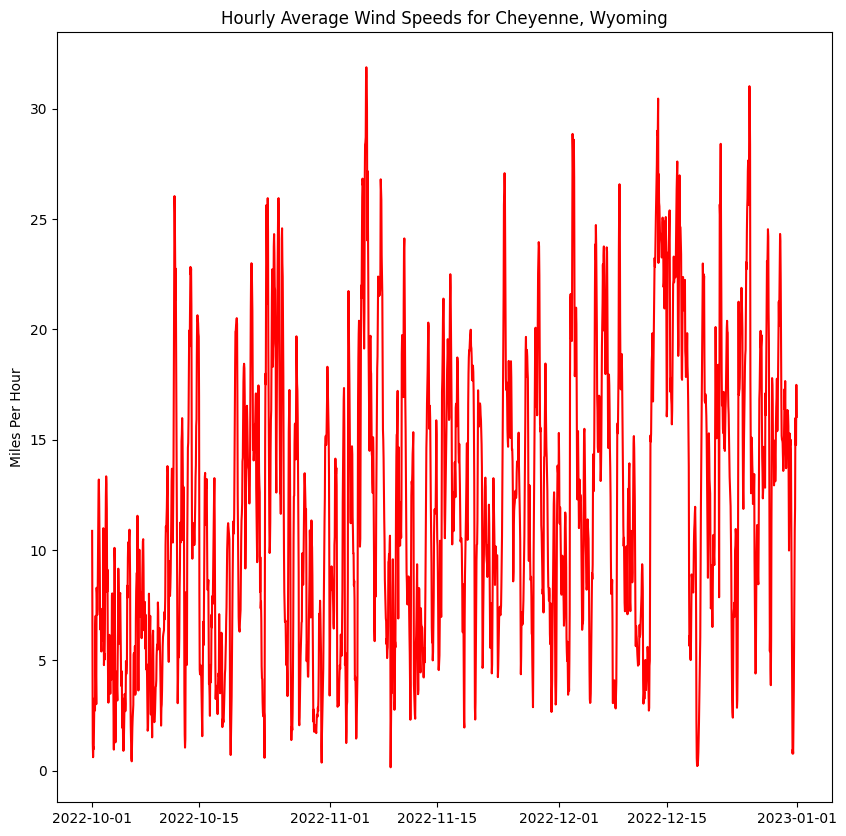

In [9]:
figure = plot_winds(u_values, v_values, ds_u.time)

plt.show()